### Creating a test file from the inference test:

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path

import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

from SEIR import NPI, setup, file_paths
from SEIR.utils import config
import pathlib
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
all_runs = {'Scenario Projections - Optimistic - 300x300':{
    'path':'s3pull/shauntrue/shaun/',
    'config':'s3pull/shauntrue/shaun/USA-20210117T182809/config_inference_med_statelevel_SeasLocNPI.yml'}
            'State level - perturbation sd=0.01 - Seas Loc NPIs - 300x1000':{
    'path':'s3pull/shauntrue/shaun221/',
    'config':'s3pull/shauntrue/shaun221/USA-20210115T060221/config_inference_med_statelevel_SeasLocNPI.yml'
}

In [1]:
config.clear()
config.read(user=False)
config.set_file(f'')
scenario = 'inference'
deathrate = 'med'
spatial_config = config["spatial_setup"]
stoch_traj_flag = True
index = 0
run_id = 0
prefix = 0
spatial_base_path = pathlib.Path('SD_2000_sim_final/USA-20201120T003501/' + spatial_config["base_path"].get())
scenario = scenario
deathrate = deathrate
stoch_traj_flag= stoch_traj_flag # Truthy: stochastic simulation, Falsy: determnistic mean of the binomial draws
nsim = 10
interactive = False
write_csv = False
write_parquet = True
npi_df = []

s = setup.Setup(
    setup_name=config["name"].get() + "_" + str(scenario),
    spatial_setup=setup.SpatialSetup(
        setup_name=spatial_config["setup_name"].get(),
        geodata_file=spatial_base_path / spatial_config["geodata"].get(),
        mobility_file=spatial_base_path / spatial_config["mobility"].get(),
        popnodes_key=spatial_config["popnodes"].get(),
        nodenames_key=spatial_config["nodenames"].get()
    ),
    nsim=nsim,
    npi_scenario=scenario,
    npi_config=config["interventions"]["settings"][scenario],
    seeding_config=config["seeding"],
    ti=config["start_date"].as_date(),
    tf=config["end_date"].as_date(),
    interactive=interactive,
    write_csv=write_csv,
    write_parquet=write_parquet,
    dt=config["dt"].as_number(),
    first_sim_index = index,
    in_run_id = run_id,
    in_prefix = prefix,
    out_run_id = run_id,
    out_prefix = prefix
)

folder = [x for x in Path(f'SD_2000_sim_final/snpi/').glob('**') if not x.is_file()]

folder.reverse()

betas = []

for fold in folder:
    print(fold)
    print(f'Exploring {str(fold)[:]} ... ', end = '')
    files_loaded = 0
    for hpar_fn in Path(str(fold)).rglob('*.parquet'):
        hpar_fn = str(hpar_fn)
        if ('chimeric' not in hpar_fn):
            #hpar =  pq.read_table(hpar_fn).to_pandas()
            #delay = int(list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'delay')].value)[0])
            #vals = list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'probability')].value)
            #hospf = pq.read_table(hpar_fn.replace('hpar', 'hosp')).to_pandas()
            #seirf = pq.read_table(hpar_fn.replace('hpar', 'seir')).to_pandas()
            snpi = pq.read_table(hpar_fn).to_pandas()
            #spar = pq.read_table(hpar_fn.replace('hpar', 'spar')).to_pandas()
            npi = NPI.NPIBase.execute(
                npi_config=s.npi_config,
                global_config=config,
                geoids=s.spatset.nodenames,
                loaded_df = snpi)
            p_draw = setup.parameters_load(hpar_fn.replace('snpi', 'spar')[:-8],
                'parquet',
                len(s.t_inter),
                s.nnodes
            )
            
            parameters = setup.parameters_reduce(p_draw, npi, s.dt)
            betas.append(parameters[1])
            
            #reduc = snpi.set_index('npi_name').T
            #reduc.columns = [n.lower() for n in reduc.columns]
            #reduc = reduc.loc[['reduction','geoid']].T.reset_index()
            #reduc['reduction'] = pd.to_numeric(reduc['reduction'])
            #npi_df = npi_df.append(reduc)

            files_loaded += 1

    print(files_loaded, 'files read')

NameError: name 'config' is not defined

In [7]:
print('ds')

ds


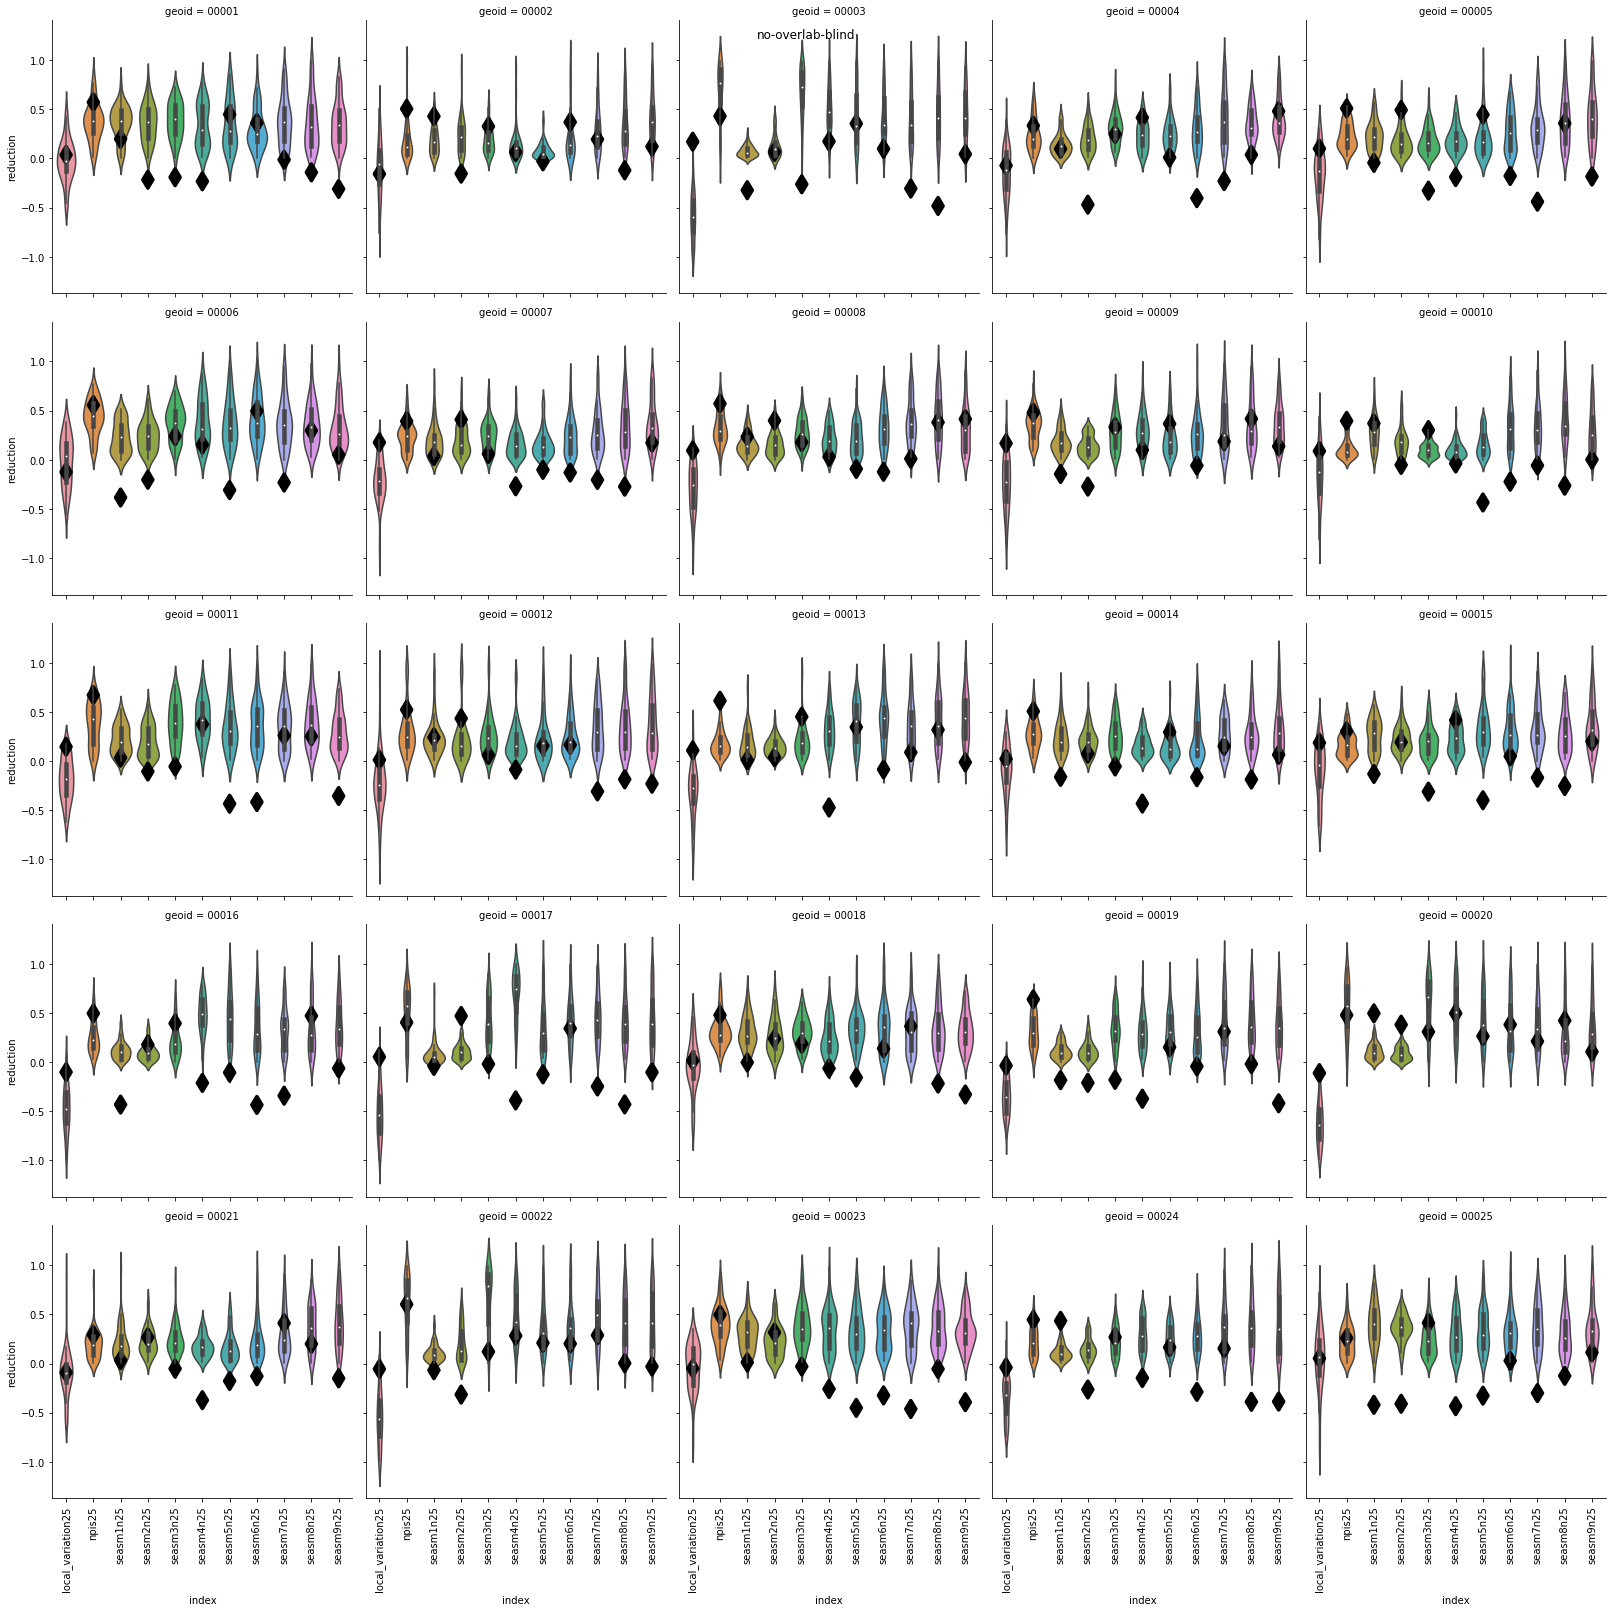

In [3]:
iris = npi_df
#iris = iris.sort_values('index')
#iris = iris[iris['geoid'].isin(['00001', '00002', '00003'])]

grid = sns.FacetGrid(iris, col="geoid", hue="geoid", palette="tab20c", height=4.5, col_wrap=5)


def quantile_plot(index, reduction, **kwargs):
    sns.violinplot(x=index, y=reduction, #hue="geoid",
                   dodge=True,  zorder=1)#Ç, scale='width')#, alpha=.25,capsize=.8, size = .2, errwidth=.75);
    sns.pointplot(x="index", y="reduction", data = npi_truth[npi_truth['geoid']==kwargs['label']], dodge=.532, join=False, #palette="dark",
              markers="d", scale=1.75, ci=None,zorder=102, color="black")
    #plt.scatter((1,1),  **kwargs)

# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, 'index', "reduction" )#, marker="o")

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
# Adjust the arrangement of the plots
grid.fig.suptitle(run_name)

grid.fig.tight_layout(w_pad=1)

In [4]:
grid.savefig('npi_vals.pdf')

In [5]:
pdf.savefig(grid.fig)

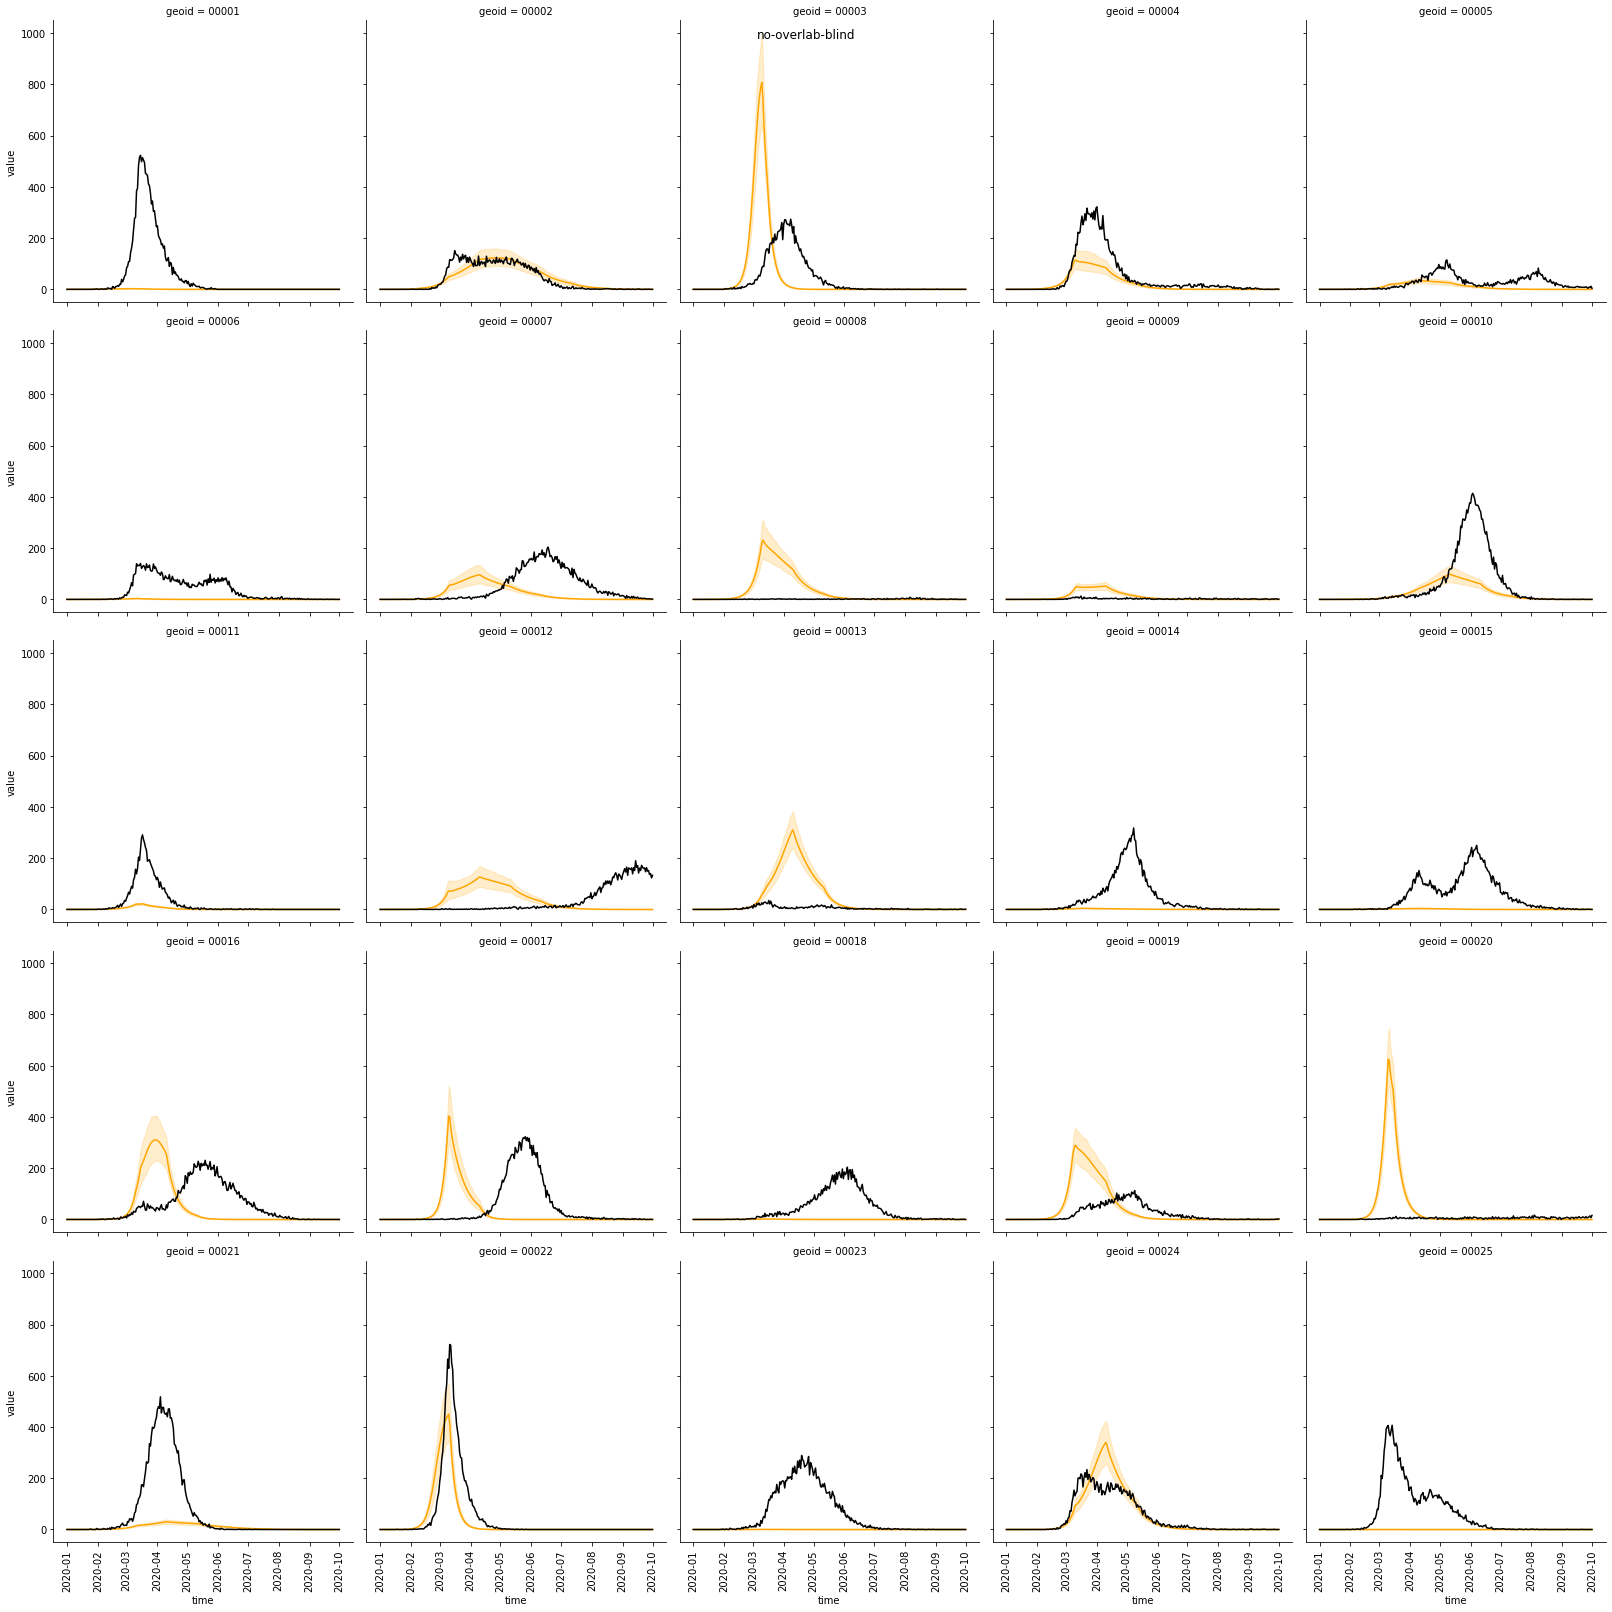

In [6]:
iris = hosp_df[hosp_df['comp']=='incidC']
#iris = iris.sort_values('index')
#iris = iris[iris['geoid'].isin(['00001', '00002', '00003'])]

grid = sns.FacetGrid(iris, col="geoid", hue="geoid", palette="tab20c", height=4.5, col_wrap=5)

# Draw a horizontal line to show the starting point
#grid.map(plt.axhline, y=0, ls=":", c=".5")

def quantile_plot(index, reduction, **kwargs):
    sns.lineplot(x=index, y=reduction, color = 'orange',#hue="geoid",
                    zorder=1)#Ç, scale='width')#, alpha=.25,capsize=.8, size = .2, errwidth=.75);
    sns.lineplot(x="time", y="value", data = hosp_truth[(hosp_truth['comp']=='incidC') & (hosp_truth['geoid']==kwargs['label'])],color="black")
                  #dodge=.532, join=False, #palette="dark",
             # markers="d", scale=1.75, ci=None,zorder=102, 
    #plt.scatter((1,1),  **kwargs)

# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, 'time', "value" )#, marker="o")

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
# Adjust the arrangement of the plots
grid.fig.suptitle(run_name)

grid.fig.tight_layout(w_pad=1)

In [7]:
pdf.savefig(grid.fig)

In [14]:
betas = np.array(betas)

In [46]:
betas = betas[:,::4,:]

In [8]:
#all_vals = np.array(all_vals)
#fig, ax = plt.subplots(7,8, figsize = (20,20), sharex = True)
#for i in range(50):
#    ax.flat[i].hist(all_vals[i::50])
#    ax.flat[i].set_title('geoid' + str(i))

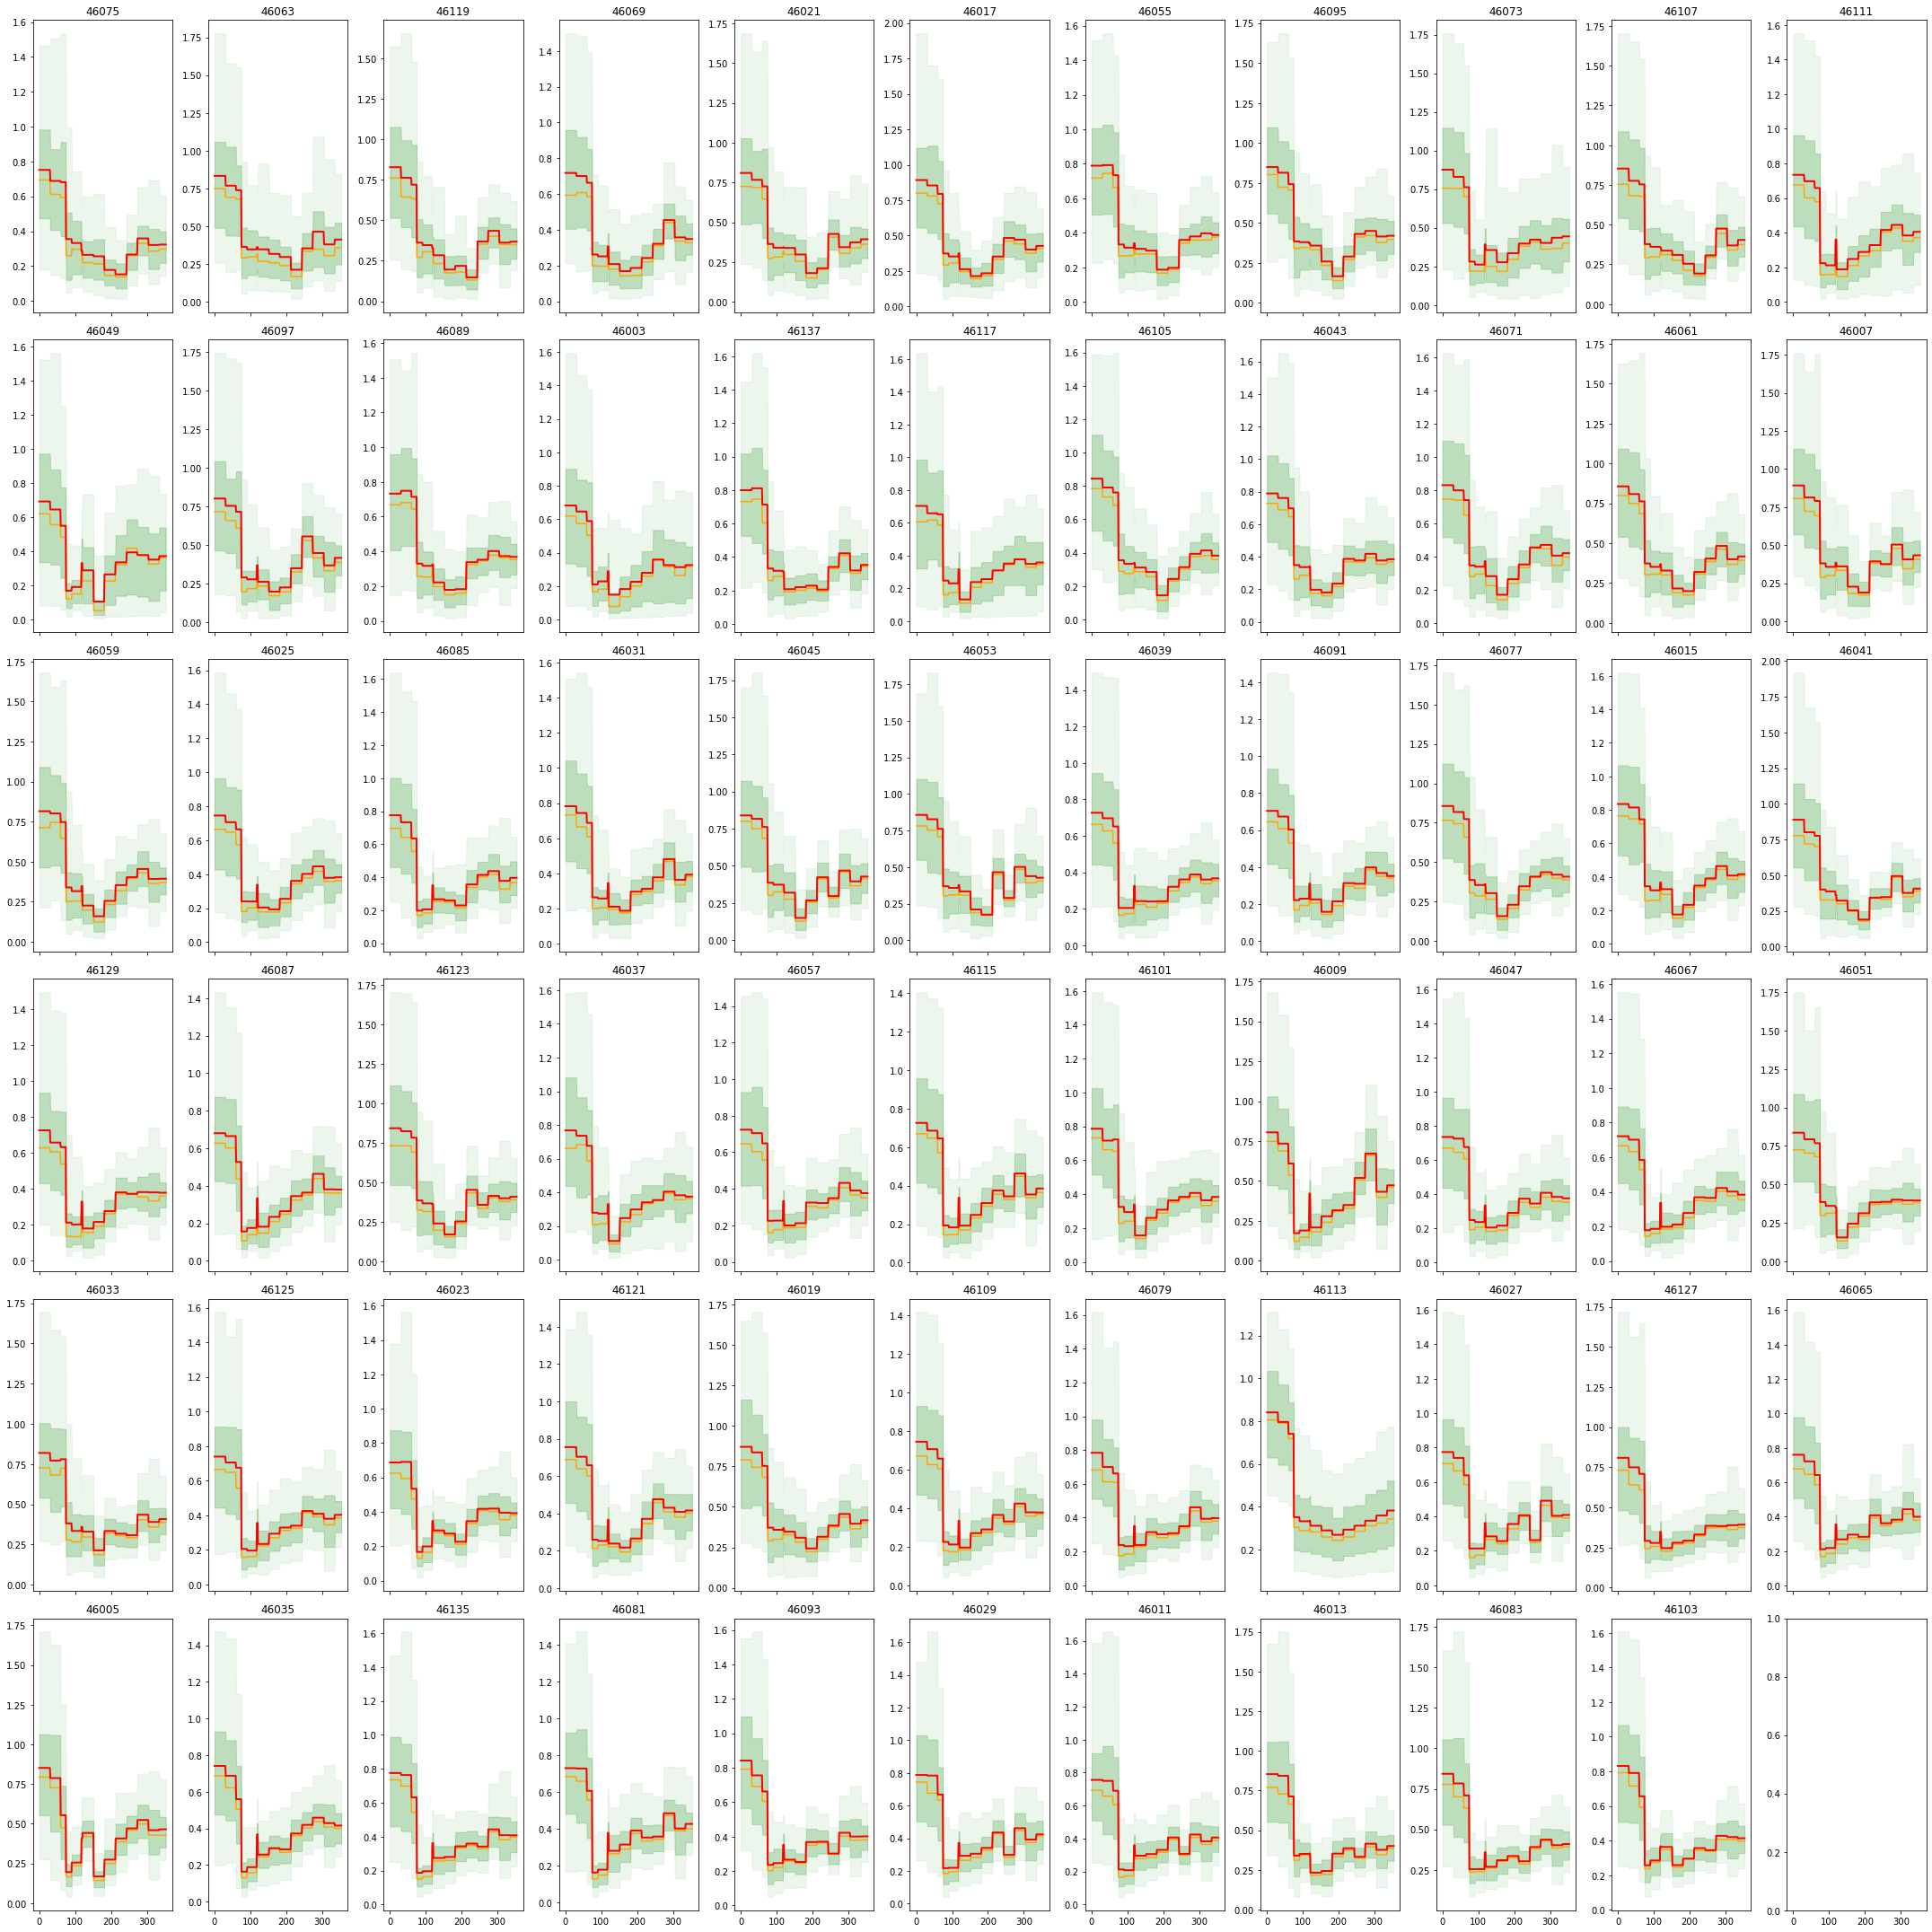

In [47]:
betas = np.array(betas)
fig, ax = plt.subplots(65//10,11, figsize = (30,30), sharex = True)
for i in range(65):
    beta = betas[:,:,i].T
    #ax.flat[i].plot(beta[:,:20], color = 'b', lw = .5, alpha = .5)
    ax.flat[i].fill_between(np.arange(beta.shape[0]), np.quantile(beta,.05,axis=1), np.quantile(beta,.95,axis=1), alpha = .07, color = 'g')
    ax.flat[i].fill_between(np.arange(beta.shape[0]), np.quantile(beta,.25,axis=1), np.quantile(beta,.75,axis=1), alpha = .2, color = 'g')
    ax.flat[i].plot(np.quantile(beta,.5,axis=1), color = 'orange', alpha = 1)
    ax.flat[i].plot(np.mean(beta, axis=1), color = 'r', alpha = 1, lw =2)
    #ax.flat[i].plot(beta_truth[:,i], color = 'k', lw =2)
    ax.flat[i].set_title(s.spatset.nodenames[i])
#fig.suptitle('black is truth | red is mean | blue is 90%');
fig.tight_layout()

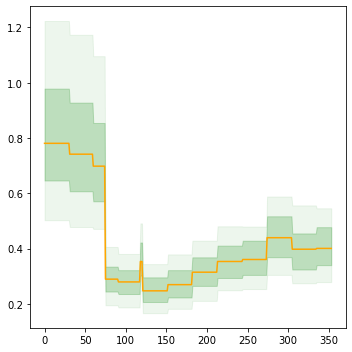

In [48]:

fig, ax = plt.subplots(1,1, figsize = (5,5), sharex = True)

all_beta = np.sum(betas, axis=2)

all_beta = np.zeros_like(betas[:,:,0])
for pl in range(betas.shape[2]):
    all_beta += betas[:,:,pl] * s.spatset.popnodes[pl]
    
all_beta /= s.spatset.popnodes.sum()
    

#ax.flat[i].plot(beta[:,:20], color = 'b', lw = .5, alpha = .5)
ax.fill_between(np.arange(all_beta.shape[1]), np.quantile(all_beta,.05,axis=0), np.quantile(all_beta,.95,axis=0), alpha = .07, color = 'g')
ax.fill_between(np.arange(all_beta.shape[1]), np.quantile(all_beta,.25,axis=0), np.quantile(all_beta,.75,axis=0), alpha = .2, color = 'g')
ax.plot(np.quantile(all_beta,.5,axis=0), color = 'orange', alpha = 1)
#ax.plot(np.mean(beta, axis=1), color = 'r', alpha = 1, lw =2)
#ax.flat[i].plot(beta_truth[:,i], color = 'k', lw =2)
#ax.flat[i].set_title('geoid' + str(i))
#fig.suptitle('black is truth | red is mean | blue is 90%');
fig.tight_layout()

In [10]:
fig.savefig('beta_vals.pdf')

In [31]:
betas.shape

(300, 1413, 66)

In [12]:
pdf.close()

In [19]:
np.quantile(np.sumbeta,.5,axis=1).shape

(300,)

In [24]:
np.sum(betas, axis=2

(300, 1413)

In [36]:
betas.shape

(300, 1413, 66)

In [49]:
1400/4

350.0